# **Predicting Hazardous NEOs (Nearest Earth Objects)**

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

### Data exploring

In [58]:
df = pd.read_csv('nearest-earth-objects(1910-2024).csv')
df.sample(10)

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
258505,3184153,(2004 MO1),23.20,0.060891,0.136157,Earth,110710.002042,1.306354e+07,False
285650,3428255,(2008 SD85),23.09,0.064055,0.143232,Earth,48388.459864,2.847436e+07,False
291893,3724242,(2015 OV),23.60,0.050647,0.113250,Earth,24797.553825,1.121434e+07,False
65602,54213623,(2021 UL4),24.19,0.038597,0.086306,Earth,42573.330898,2.914656e+07,False
205104,3836854,(2018 XT2),22.10,0.101054,0.225964,Earth,4230.661035,5.614724e+07,False
212168,3681965,(2014 PT59),20.23,0.239086,0.534614,Earth,22995.052288,2.574158e+07,False
11733,3359282,(2006 WN3),19.84,0.286124,0.639794,Earth,49846.223881,5.996619e+07,False
27306,2159609,159609 (2002 AQ3),17.23,0.951820,2.128335,Earth,72573.758178,5.677960e+07,False
51151,3520666,(2010 JV34),20.85,0.179703,0.401828,Earth,95349.210422,6.026343e+07,True
45217,2503861,503861 (1998 WZ1),19.97,0.269498,0.602615,Earth,53060.842382,3.168624e+07,True


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [60]:
df.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

In [61]:
df.duplicated().sum()

0

#### Data issues

1. Null values in coloum(absolute_magnitude,estimated_diameter_min,estimated_diameter_max)

## Data cleaning

#### Handle null values

In [62]:
df['absolute_magnitude'] = df['absolute_magnitude'].fillna(df['absolute_magnitude'].mean())
df['estimated_diameter_min'] = df['estimated_diameter_min'].fillna(df['estimated_diameter_min'].mean())
df['estimated_diameter_max'] = df['estimated_diameter_max'].fillna(df['estimated_diameter_max'].mean())
df.isnull().sum()

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

## Exploratory Data Analysis (EDA)

#### 1. What are the unique values in orbiting_body and distribution?

orbiting_body
Earth    338199
Name: count, dtype: int64


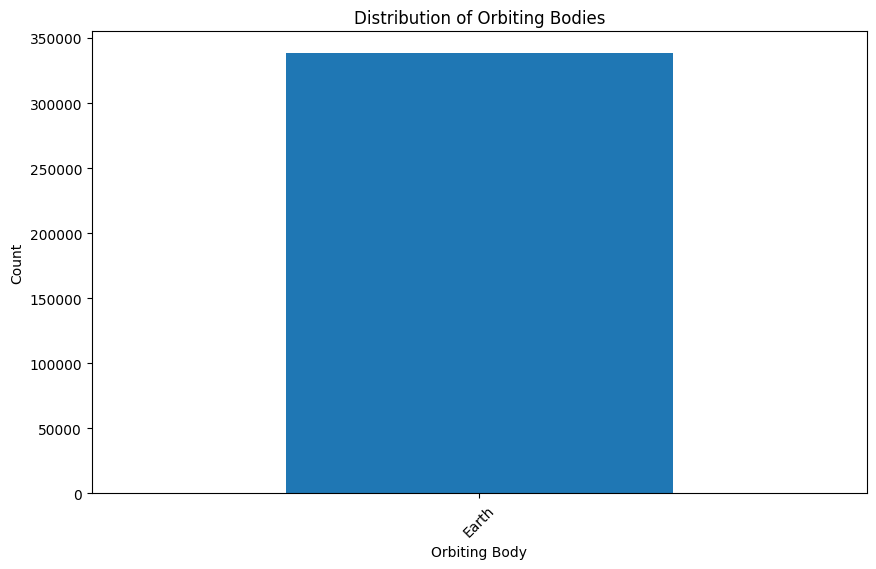

In [63]:
##  What are the unique values in orbiting_body and distribution?
orbiting_body = df['orbiting_body'].value_counts()
print(orbiting_body)

plt.figure(figsize=(10,6))
orbiting_body.plot(kind='bar')
plt.title('Distribution of Orbiting Bodies')
plt.xlabel('Orbiting Body')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### 2. What is the distribution of is_hazardous?

is_hazardous
False    295037
True      43162
Name: count, dtype: int64


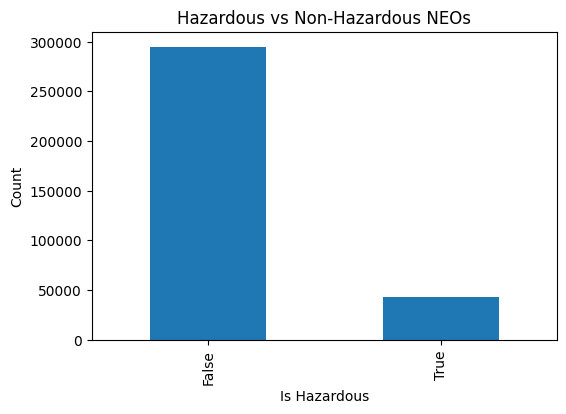

In [64]:
## What is the distribution of is_hazardous?
hazardous_counts = df['is_hazardous'].value_counts()
print(hazardous_counts)

plt.figure(figsize=(6,4))
df['is_hazardous'].value_counts().plot(kind='bar')
plt.title('Hazardous vs Non-Hazardous NEOs')
plt.xlabel('Is Hazardous')
plt.ylabel('Count')
plt.show()


#### 3. What is the average absolute_magnitude of hazardous?

In [65]:
## What is the average absolute_magnitude of hazardous?
avg_magnitude_hazardous = df.groupby('is_hazardous')['absolute_magnitude'].mean()
print(avg_magnitude_hazardous)

is_hazardous
False    23.315543
True     20.314378
Name: absolute_magnitude, dtype: float64


#### 4.  What is the distribution of relative_velocity?

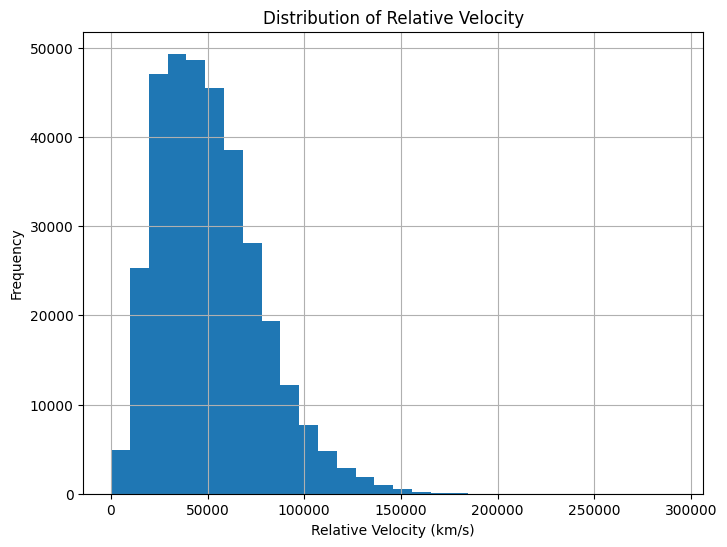

In [66]:
##  What is the distribution of relative_velocity?
plt.figure(figsize=(8,6))
df['relative_velocity'].hist(bins=30)
plt.title('Distribution of Relative Velocity')
plt.xlabel('Relative Velocity (km/s)')
plt.ylabel('Frequency')
plt.show()

#### 5. What are the average relative_velocity and miss_distance for each orbiting_body?

In [67]:
## What are the average relative_velocity and miss_distance for each orbiting_body?
avg_orbiting_body = df.groupby('orbiting_body')[['relative_velocity', 'miss_distance']].mean()
print(avg_orbiting_body)

               relative_velocity  miss_distance
orbiting_body                                  
Earth               51060.662908   4.153535e+07


#### 6. What is the average estimated_diameter_max for hazardous NEOs and non-hazardous ones?

In [68]:
## What is the average estimated_diameter_max for hazardous NEOs and  non-hazardous ones?
avg_diameter_max_hazardous = df.groupby('is_hazardous')['estimated_diameter_max'].mean()
print(avg_diameter_max_hazardous)

is_hazardous
False    0.308628
True     0.655353
Name: estimated_diameter_max, dtype: float64


#### 7. What is the distribution of miss_distance?

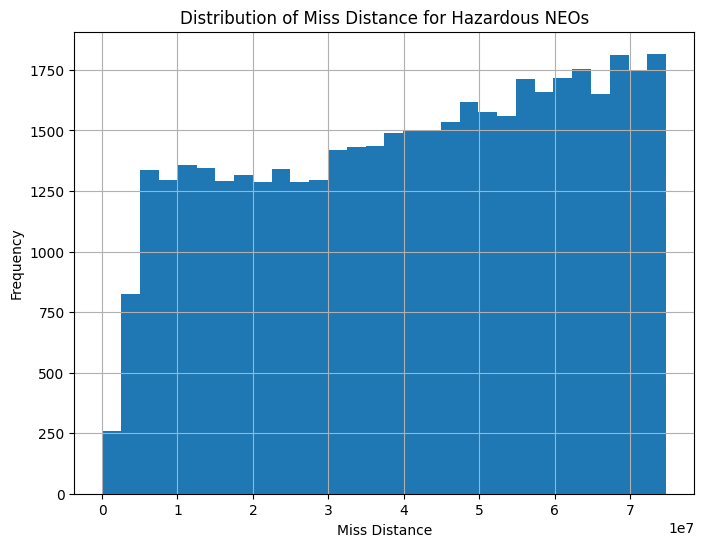

In [69]:
## What is the distribution of miss_distance?
plt.figure(figsize=(8,6))
df[df['is_hazardous'] == True]['miss_distance'].hist(bins=30)
plt.title('Distribution of Miss Distance for Hazardous NEOs')
plt.xlabel('Miss Distance')
plt.ylabel('Frequency')
plt.show()

#### 8. What is the difference between estimated_diameter_min and estimated_diameter_max?

In [70]:
## What is the difference between estimated_diameter_min and estimated_diameter_max?
deff = df[['estimated_diameter_min', 'estimated_diameter_max']].describe()
print(deff)

       estimated_diameter_min  estimated_diameter_max
count           338199.000000           338199.000000
mean                 0.157812                0.352878
std                  0.313872                0.701839
min                  0.000511                0.001143
25%                  0.025384                0.056760
50%                  0.073207                0.163697
75%                  0.189041                0.422708
max                 37.545248               83.953727


#### 9. What is the distribution of the absolute_magnitude?

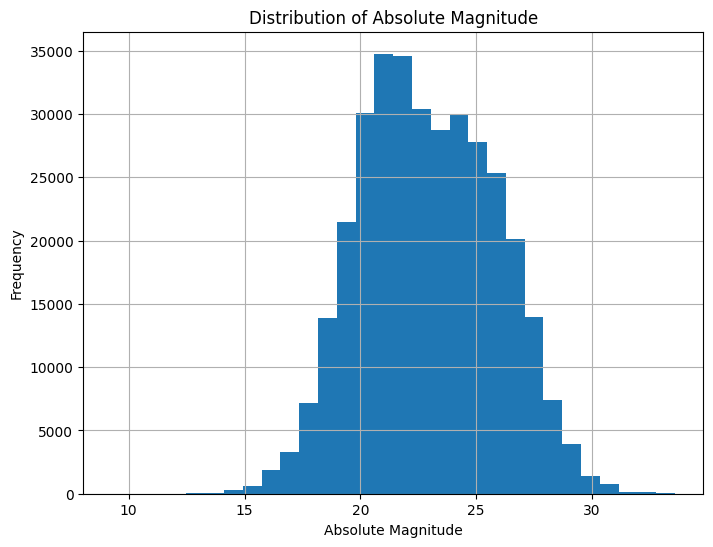

In [71]:
## What is the distribution of the absolute_magnitude?
plt.figure(figsize=(8,6))
df['absolute_magnitude'].hist(bins=30)
plt.title('Distribution of Absolute Magnitude')
plt.xlabel('Absolute Magnitude')
plt.ylabel('Frequency')
plt.show()

## Data Preprocessing

#### Encode categorical variables

In [72]:
encoder = LabelEncoder()
df['orbiting_body'] = encoder.fit_transform(df['orbiting_body'])

#### Scaling numerical features

In [73]:
scaler = StandardScaler()
df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 
    'relative_velocity', 'miss_distance']] = scaler.fit_transform(df[['absolute_magnitude', 
    'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']])

#### Feature selection

In [74]:
## Add a new column for the diameter range
df['diameter'] = df['estimated_diameter_max'] - df['estimated_diameter_min']
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous,diameter
0,2162117,162117 (1998 SD15),-1.302784,0.755562,0.755562,0,0.783537,0.799476,False,1.143422e-10
1,2349507,349507 (2008 QY),-1.522633,1.186882,1.186882,0,2.230715,0.686711,True,9.590506e-11
2,2455415,455415 (2003 GA),-0.509268,-0.068479,-0.068479,0,-0.992271,1.235756,False,-1.229380e-10
3,3132126,(2002 PB),-0.790949,0.130790,0.130790,0,1.054176,-0.536196,False,1.502612e-10
4,3557844,(2011 DW),-0.079876,-0.258559,-0.258559,0,0.188485,1.038958,False,-1.924109e-10


#### Handling imbalanced classe (is_hazardous) using: Undersampling

In [77]:
X = df.drop(columns=['is_hazardous'])
y = df['is_hazardous']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

undersample = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

print("Before undersampling:", y_train.value_counts())
print("After undersampling:", y_train_resampled.value_counts())

Before undersampling: is_hazardous
False    206569
True      30170
Name: count, dtype: int64
After undersampling: is_hazardous
False    30170
True     30170
Name: count, dtype: int64


## Training and Evaluation

### Training

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc

df['is_hazardous'] = df['is_hazardous'].astype(int)

X = df.drop(columns=['is_hazardous'])  
y = df['is_hazardous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

### Evaluation

In [84]:
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc_roc:.2f}")

Precision: 0.48
Recall: 0.07
F1-Score: 0.13
AUC-ROC: 0.84


### Plot AUC-ROC curve

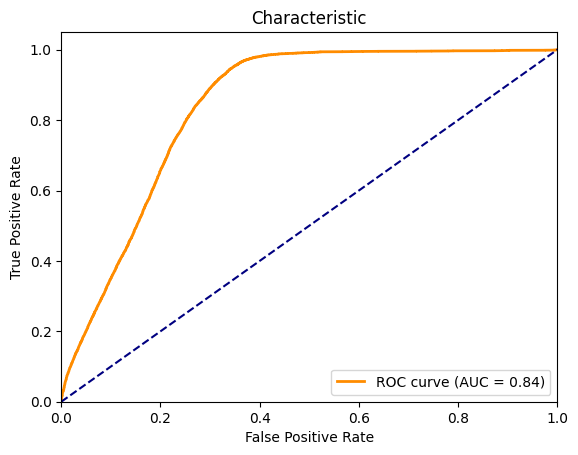

In [87]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Characteristic')
plt.legend(loc="lower right")
plt.show()